In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [2]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

In [3]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [45]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n

def expE(nbar, omega, Ncut):
    expE = 0.0
    #Ncut = 1001
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def expEHeat(nbar0, nbarf, omega, Ncut):
    return expE((nbar0+nbarf)/2.0, omega, Ncut)

def dopAndStark(nbar):
    Ncut = 1201
    #nbar0 = 0.0
    omega = 2.0*np.pi*778e3 #Lange
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -100*nu0*expE(nbar, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))

def dopAndStark2(n):
    omega = 2.0*np.pi*778e3 #Lange
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -100*nu0*hbar*omega*(0.5+n)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))

In [42]:
def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def phi(psi):
    phi0 = math.atan2(np.real(psi[0]),np.imag(psi[0]))
    phi1 = math.atan2(np.real(psi[1]),np.imag(psi[1]))
    return (phi0-phi1)

def blochVec(psi):
    w = rhogg(psi) - rhoee(psi)  #pointed up is ground state
    if abs(w)>1.0:
        w = float(round(w))
    x = np.sin(np.arccos(w))*np.cos(phi(psi))
    y = np.sin(np.arccos(w))*np.sin(phi(psi))
    return np.array([x,y,w])

In [26]:
phi=0
nbar0 = 0.0
nbarf = 40.0
tsteps=1000
T = 500e-3
ts = np.linspace(0.0, T, tsteps)
nbars=np.linspace(nbar0, nbarf, tsteps)
for ii in range(tsteps):
    phi += T/tsteps*dopAndStark(nbars[ii])

In [27]:

T = 500e-3
phi1 = T/2.0*(dopAndStark(nbar0)+dopAndStark(nbarf))

In [28]:
phi

-0.0009475106167750694

In [29]:
phi1

-0.0009475106167715271

In [23]:
dopAndStark(nbarf)

-0.0037438224369995077

In [25]:
T/tsteps

0.0005

In [46]:
T = 500e-3
t1= 20e-3
t2= 60e-3
Omega0= np.pi/(2*t1)
eta=0.05
Ncut=401
nbar0=0
nbarf=40
phase = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
delPrime=0.0
delp1 = delPrime
delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0)

psi0 = psi(1.0,0.0)
psi1 = thermPulse(psi0, t1, Omega0, delp1, eta, nbar0, Ncut)
psi2 = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)@psi1
psi3 = pulse(0.0, 0.0, 0.0, 0.0, phase)@psi2
psi4a = thermPulse(psi3, t1, Omega0, delp2, eta, nbar0, Ncut)
psi4b = thermPulse(psi4a, t1, Omega0, delp2, eta, nbar0, Ncut)
psi4c = thermPulse(psi4b, t1, Omega0, delp2, eta, nbar0, Ncut)


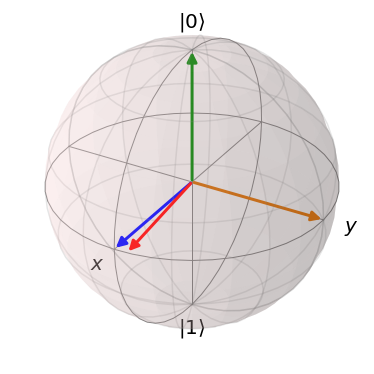

In [50]:
b = Bloch()
#b.view = [-150, 30]
b.add_vectors(blochVec(psi0))
b.add_vectors(blochVec(psi1))
b.add_vectors(blochVec(psi2))
b.add_vectors(blochVec(psi3))
#b.add_vectors(blochVec(psi4a))
#b.add_vectors(blochVec(psi4b))
#b.add_vectors(blochVec(psi4c))

b.show()

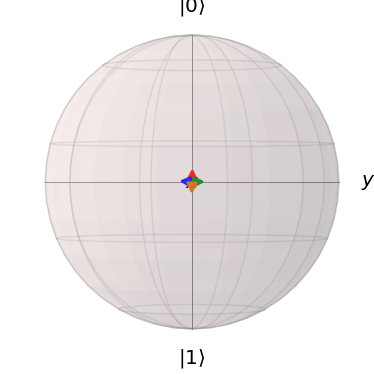

In [59]:
b = Bloch()
b.view = [-90, 0]
b.add_vectors(blochVec(psi3))
b.add_vectors(blochVec(psi4a))
b.add_vectors(blochVec(psi4b))
b.add_vectors(blochVec(psi4c))
b.show()

In [68]:
T = 500e-3
t1= 20e-3
t2= 60e-3
Omega0= np.pi/(2*t1)
eta=0.05
Ncut=401
nbar0=0
nbarf=40
phase = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
delPrime=0.0
delp1 = delPrime
delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0)

psi0a = psi(1.0,0.0)
psi1a = thermPulse(psi0a, t1, Omega0, delp1, eta, nbar0, Ncut)
psi2a = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)@psi1a
psi3a = pulse(0.0, 0.0, 0.0, 0.0, phase)@psi2a
psi4aa = thermPulse(psi3a, t1, Omega0, delp2, eta, nbar0, Ncut)
psi4ba = thermPulse(psi4aa, t1, Omega0, delp2, eta, nbar0, Ncut)
psi4ca = thermPulse(psi4ba, t1, Omega0, delp2, eta, nbar0, Ncut)

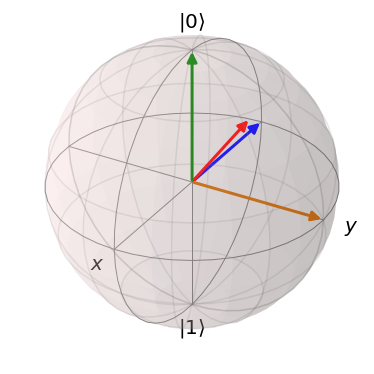

In [70]:
b = Bloch()
#b.view = [-150, 30]
b.add_vectors(blochVec(psi0a))
b.add_vectors(blochVec(psi1a))
b.add_vectors(blochVec(psi2a))
b.add_vectors(blochVec(psi3a))
#b.add_vectors(blochVec(psi4aa))
#b.add_vectors(blochVec(psi4ba))
#b.add_vectors(blochVec(psi4ca))

b.show()

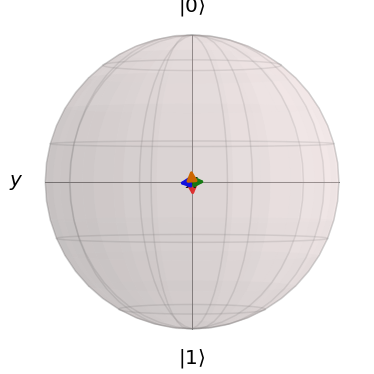

In [77]:
b = Bloch()
b.view = [90, 0]
b.add_vectors(blochVec(psi3a))
b.add_vectors(blochVec(psi4aa))
b.add_vectors(blochVec(psi4ba))
b.add_vectors(blochVec(psi4ca))
b.show()

In [60]:
T = 500e-3
t1= 20e-3
t2= 60e-3
Omega0= np.pi/(2*t1)
eta=0.05
Ncut=401
nbar0=0
nbarf=40
phase = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
delPrime=0.0
delp1 = delPrime
delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0)

psi0s = psi(1.0,0.0)
psi1s = thermPulse(psi0s, t1, Omega0, delp1, eta, nbar0, Ncut)
psi2s = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)@psi1s
psi3s = pulse(0.0, 0.0, 0.0, 0.0, phase)@psi2s
psi4as = thermPulse(psi3s, t1, -Omega0, delp2, eta, nbar0, Ncut)
psi4bs = thermPulse(psi4as, t1, -Omega0, delp2, eta, nbar0, Ncut)
psi4cs = thermPulse(psi4bs, t1, Omega0, delp2, eta, nbar0, Ncut)

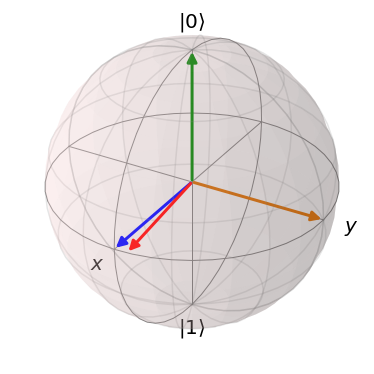

In [63]:
b = Bloch()
#b.view = [-150, 30]
b.add_vectors(blochVec(psi0s))
b.add_vectors(blochVec(psi1s))
b.add_vectors(blochVec(psi2s))
b.add_vectors(blochVec(psi3s))
#b.add_vectors(blochVec(psi4as))
#b.add_vectors(blochVec(psi4bs))
#b.add_vectors(blochVec(psi4cs))

b.show()

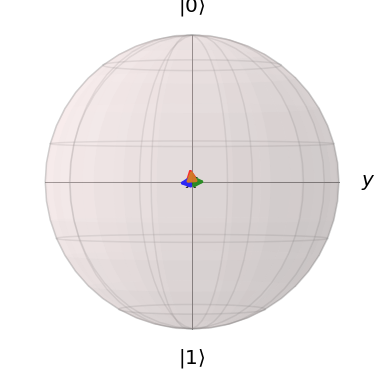

In [67]:
b = Bloch()
b.view = [-90, 0]
b.add_vectors(blochVec(psi3s))
b.add_vectors(blochVec(psi4as))
b.add_vectors(blochVec(psi4bs))
b.add_vectors(blochVec(psi4cs))
b.show()